In [1]:
import os
import numpy as np
import pandas as pd
from dython.nominal import theils_u
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util

In [2]:
data_dir = os.environ['DATA_DIR']
img_dir = os.environ['IMG_DIR']
nb_dir = os.path.join(os.path.split(data_dir)[0], 'notebooks')

spec = importlib.util.spec_from_file_location("calc_enrichment_score", os.path.join(nb_dir, "enrichment.py"))
enr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(enr)

In [3]:
isolates_data_fp = os.path.join(data_dir, 'isolates.tsv')
active_enrichment_table =  os.path.join(data_dir, 'table1.tsv')
data_covariance_fig =  os.path.join(img_dir, 'category_covariance.png')

In [4]:
strains_df = pd.read_csv(isolates_data_fp, sep='\t')
strains_df.head(3)

,strain_id,selection_tool,sample_type,country,state,phylum,class,order,family,genus,...,sa_confirmed_activity,sa_purity_test,sa_purity_confirmed,bs_primary_test,bs_confirmation_test,bs_confirmed_activity,bs_purity_test,bs_purity_confirmed,sa_ml_disease_ctrl,bs_ml_disease_ctrl
0,AFS000005,genome_similarity,Soil,Uganda,Amuria,Firmicutes,Bacilli,Bacillales,Bacillaceae_H,Bacillus_C,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,AFS000006,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,35.0
2,AFS000009,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,1,1,1,1.0,1.0,1.0,1.0,1.0,NaN,80.0


### Generate summary statistics

In [5]:
initial_strains_df = strains_df[~strains_df.selection_tool.str.contains('machine_learning')]
initial_strains_df.shape

(1051, 23)

In [6]:
phases = ['_primary_test', '_confirmation_test', '_confirmed_activity']
pathos = ['sa', 'bs']
for pt in pathos:
    print(f'{pt}')
    ist = initial_strains_df[initial_strains_df[f'{pt}_primary_test'] == 1]
    print('total:', ist.shape[0])
    for t, t_df in ist.groupby('selection_tool'):
        print('\t', t)
        t = t_df.shape[0]
        p = t_df[f'{pt}_confirmation_test'].sum()
        c = t_df[f'{pt}_confirmed_activity'].sum()
        print('\t\tprimary:', p, t, p / t, 'conf:', c, t, c / t)

sa
total: 1051
	 diversity
		primary: 28 546 0.0512820512821 conf: 8 546 0.014652014652
	 genome_similarity
		primary: 30 214 0.140186915888 conf: 15 214 0.0700934579439
	 spectrum
		primary: 35 291 0.120274914089 conf: 18 291 0.0618556701031
bs
total: 559
	 diversity
		primary: 13.0 145 0.0896551724138 conf: 2.0 145 0.0137931034483
	 genome_similarity
		primary: 16.0 155 0.103225806452 conf: 10.0 155 0.0645161290323
	 spectrum
		primary: 23.0 259 0.0888030888031 conf: 18.0 259 0.0694980694981


In [7]:
strains_df[(strains_df['sa_confirmation_test'] == 1) | (strains_df['bs_confirmation_test'] == 1)].shape

(156, 23)

In [8]:
strains_df[(strains_df['sa_confirmed_activity'] == 1) & (strains_df['bs_confirmed_activity'] == 1)].shape

(12, 23)

In [9]:
strains_df[(strains_df['sa_confirmed_activity'] == 1)].shape[0], \
strains_df[(strains_df['sa_confirmed_activity'] == 1)].phylum.nunique(), \
strains_df[(strains_df['sa_confirmed_activity'] == 1)].genus.nunique(),

(53, 4, 9)

In [10]:
strains_df[(strains_df['bs_confirmed_activity'] == 1)].shape[0], \
strains_df[(strains_df['bs_confirmed_activity'] == 1)].phylum.nunique(), \
strains_df[(strains_df['bs_confirmed_activity'] == 1)].genus.nunique(),

(31, 4, 8)

In [11]:
initial_strains_df.query('selection_tool == "diversity"').query('bs_primary_test == 1').shape

(145, 23)

In [12]:
taxa = ['phylum', 'class', 'order', 'family', 'genus', 'species']
for t in taxa:
    print(t, initial_strains_df[t].nunique())
    for pt in pathos:
        for p in phases:
            print('\t', pt+p, initial_strains_df[initial_strains_df[pt+p] == 1][t].nunique())

phylum 5
	 sa_primary_test 5
	 sa_confirmation_test 4
	 sa_confirmed_activity 4
	 bs_primary_test 5
	 bs_confirmation_test 4
	 bs_confirmed_activity 4
class 6
	 sa_primary_test 6
	 sa_confirmation_test 4
	 sa_confirmed_activity 4
	 bs_primary_test 6
	 bs_confirmation_test 4
	 bs_confirmed_activity 4
order 21
	 sa_primary_test 21
	 sa_confirmation_test 10
	 sa_confirmed_activity 6
	 bs_primary_test 16
	 bs_confirmation_test 7
	 bs_confirmed_activity 5
family 36
	 sa_primary_test 36
	 sa_confirmation_test 12
	 sa_confirmed_activity 7
	 bs_primary_test 27
	 bs_confirmation_test 8
	 bs_confirmed_activity 6
genus 95
	 sa_primary_test 95
	 sa_confirmation_test 19
	 sa_confirmed_activity 9
	 bs_primary_test 44
	 bs_confirmation_test 12
	 bs_confirmed_activity 8
species 205
	 sa_primary_test 205
	 sa_confirmation_test 29
	 sa_confirmed_activity 17
	 bs_primary_test 69
	 bs_confirmation_test 18
	 bs_confirmed_activity 13


In [13]:
# Number of phyla represented at each phase of SA screening 
strains_df[strains_df['sa_confirmation_test'] == 1].phylum.nunique(), \
strains_df[strains_df['sa_confirmed_activity'] == 1].phylum.nunique()

(4, 4)

In [14]:
# Number of strains from Bacteroidota phylum
strains_df[strains_df.phylum == 'Bacteroidota'].shape

(9, 23)

In [15]:
# Number of phyla, genera, and species with any primary or confirmation activity
either_conf_test = strains_df[(strains_df['bs_confirmation_test'] == 1) | (strains_df['sa_confirmation_test'] == 1) ]
print('conf_test', either_conf_test.phylum.nunique(), either_conf_test.genus.nunique(), either_conf_test.species.nunique())
either_conf_act = strains_df[(strains_df['bs_confirmed_activity'] == 1) | (strains_df['sa_confirmed_activity'] == 1) ]
print('conf_act', either_conf_act.phylum.nunique(), either_conf_act.genus.nunique(), either_conf_act.species.nunique())

conf_test 5 27 37
conf_act 5 14 22


In [16]:
# Which phyla?
sa_conf_act = strains_df[strains_df['sa_confirmed_activity'] == 1]
print(sa_conf_act.phylum.unique())
print(sa_conf_act[sa_conf_act.phylum == 'Firmicutes_I'].shape)
bs_conf_act = strains_df[strains_df['bs_confirmed_activity'] == 1]
print(bs_conf_act.phylum.unique())
print(bs_conf_act[bs_conf_act.phylum == 'Bacteroidota'].shape)

['Proteobacteria' 'Firmicutes' 'Actinobacteriota' 'Firmicutes_I']
(1, 23)
['Proteobacteria' 'Firmicutes' 'Actinobacteriota' 'Bacteroidota']
(1, 23)


In [17]:
initial_strains_df.columns

Index(['strain_id', 'selection_tool', 'sample_type', 'country', 'state',
       'phylum', 'class', 'order', 'family', 'genus', 'species',
       'sa_primary_test', 'sa_confirmation_test', 'sa_confirmed_activity',
       'sa_purity_test', 'sa_purity_confirmed', 'bs_primary_test',
       'bs_confirmation_test', 'bs_confirmed_activity', 'bs_purity_test',
       'bs_purity_confirmed', 'sa_ml_disease_ctrl', 'bs_ml_disease_ctrl'],
      dtype='object')

### Estimate likelihood of each category producing observed actives by random chance

In [18]:
diversity_strains_df = strains_df.query('selection_tool == "diversity"')
diversity_actives_df = diversity_strains_df.query('sa_confirmed_activity == 1 | bs_confirmed_activity == 1')

In [19]:
assert 1 == enr.calc_enrichment_score(n=7, o=0, M=20, N=12)
assert 0 == enr.calc_enrichment_score(n=7, o=8, M=20, N=12)
assert 1 == enr.calc_enrichment_score(n=7, o=-1, M=20, N=12)

def add_missing_categories(full_dataset_counts, subset_counts):
    # Add any categories from the full dataset that are missing in the subset
    # and set to zero
    missing_categories = list(set(full_dataset_counts.index) - set(subset_counts.index))
    missing_series = pd.Series([0]*len(missing_categories), index=missing_categories)
    new_subset_counts = subset_counts.append(missing_series)
    return new_subset_counts

m1 = add_missing_categories(diversity_strains_df.groupby('sample_type').size().sort_values(ascending=False),
                            diversity_actives_df.groupby('sample_type').size().sort_values(ascending=False))
assert m1['Plant'] == 0

In [20]:
enrichment_scores_dict = {'variable':[],
                          'category': [],
                          'active_count':[],
                          'total_count':[],
                          'p_value':[]
                         }
variables_list = ['selection_tool', 'sample_type', 'country', 'state', \
                  'phylum', 'class', 'order', 'family', 'genus', 'species']

for v in variables_list:
    full_dataset_counts = (diversity_strains_df
                           .groupby(v)
                           .size()
                           .sort_values(ascending=False)
                          )

    subset_counts = (diversity_actives_df
                     .groupby(v)
                     .size()
                     .sort_values(ascending=False)
                    )
    subset_counts = add_missing_categories(full_dataset_counts, subset_counts)

    for i, count in enumerate(full_dataset_counts):
        category = full_dataset_counts.index[i]
        active_count = subset_counts.loc[category]
        p_value = enr.calc_enrichment_score(n=count, 
                                            o=active_count, 
                                            M=diversity_strains_df.shape[0], 
                                            N=diversity_actives_df.shape[0])
        
        enrichment_scores_dict['variable'].append(v)
        enrichment_scores_dict['category'].append(category)
        enrichment_scores_dict['active_count'].append(active_count)
        enrichment_scores_dict['total_count'].append(count)
        enrichment_scores_dict['p_value'].append(p_value)

enrichment_scores_df = pd.DataFrame(enrichment_scores_dict)
mt = multipletests(enrichment_scores_df['p_value'], 0.05, 'fdr_bh')
enrichment_scores_df['fdr_corrected_pval'] = mt[1]
enrichment_scores_df = enrichment_scores_df.sort_values(by='p_value')

enrichment_scores_df.head(10)

,variable,category,active_count,total_count,p_value,fdr_corrected_pval
195,species,Bacillus velezensis,2,4,0.001427,0.269025
68,family,Bacillaceae,3,19,0.002638,0.269025
100,genus,Bacillus,3,19,0.002638,0.269025
35,class,Bacilli,6,118,0.004306,0.269025
30,phylum,Firmicutes,6,118,0.004306,0.269025
4,sample_type,Soil,4,48,0.004790,0.269025
13,country,Uganda,3,32,0.012094,0.582250
291,species,MA-N2 sp002009585,1,1,0.016484,0.694368
221,species,Lysinibacillus pakistanensis,1,2,0.032725,1.000000
67,family,Planococcaceae,2,19,0.035727,1.000000


In [21]:
enrichment_scores_df.to_csv(active_enrichment_table, sep='\t', index=False)

### Check for correlations between variables

In [22]:
# calculate covariance of starting variables
correlations_mat = np.zeros([len(variables_list), len(variables_list)])
correlations_df = pd.DataFrame(data=correlations_mat, columns=variables_list, index=variables_list)
for v_x in variables_list:
    for v_y in variables_list:
        u = theils_u(diversity_strains_df[v_x], diversity_strains_df[v_y])
        correlations_df.loc[v_y, v_x] = u

https://github.com/shakedzy/dython/blob/master/dython/nominal.py

This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
x, and 1 means y provides full information about x.

You read the plot below as "if you know the value from the row, how much information does that provide about the value in the column?"
For example, if you know the `sample_type`, it gives you full information about the `selection_tool`, but the opposite is not true. 

In [23]:
theils_u(diversity_strains_df['selection_tool'], diversity_strains_df['sample_type'])

1

In [24]:
theils_u(diversity_strains_df['sample_type'], diversity_strains_df['selection_tool'])

1.2078813491824857e-16

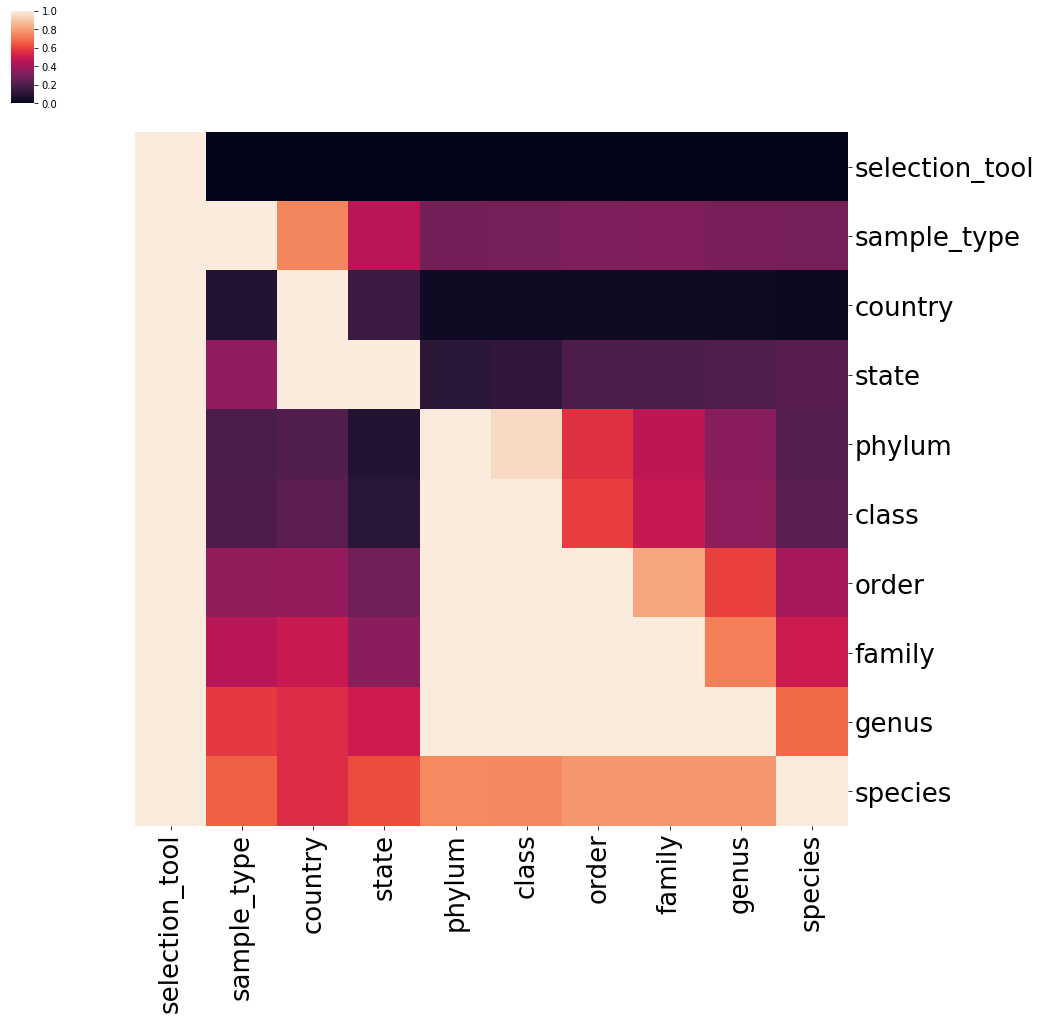

In [25]:
g = sns.clustermap(correlations_df, figsize=(15, 15), row_cluster=False, col_cluster=False, standard_scale=None)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=26);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=26);

In [26]:
g.savefig(data_covariance_fig)

In [27]:
strains_df[(strains_df.bs_confirmed_activity == 1)].shape

(31, 23)